In [1]:
import torch, pickle, argparse, os
import importlib
from fig_settings import *
from util import *
from torch.utils.data import DataLoader, random_split, Subset, ConcatDataset
import numpy as np
import seaborn as sns, glob

In [2]:
import numpy as np 
from scipy.integrate import simpson
from scipy.linalg import eigh
import math


def _flip(angles, index):
    for ii in range(index.shape[0]):
        if ii % 2 == 0:
            angles[index[ii, 0]:index[ii + 1, 0], index[ii, 1]] = math.pi - angles[index[ii, 0]:index[ii + 1, 0],
                                                                            index[ii, 1]]
    return angles


class memory_kernel_homogenized_model:
    def __init__(self, viscous=None, elastic=None, kernel=None, T=1.0):
        self._nu_p = viscous
        self._E_p = elastic
        self._kernel = kernel
        self._t = np.linspace(0.0, T, kernel.shape[0])
        self._dt = np.mean(self._t[1:] - self._t[:-1])

    def predict(self, ebar, rate):
        if isinstance(ebar, np.ndarray) and isinstance(ebar, np.ndarray):
            ebar_array = ebar
            rate_array = rate
        else:
            ebar_array = ebar(self._t)
            rate_array = rate(self._t)
        stress = np.zeros((self._t.size, self._nu_p.shape[0]))
        # stress[0] = self._nu_p @ rate_array[0]
        for ii, time in enumerate(self._t[1:]):
            step = ii + 1
            # stress[step] = self._nu_p @ rate_array[step] + self._E_p @ ebar_array[step]
            kernel_flip = np.flip(-self._kernel[:step + 1], 0)
            integrand = np.einsum("ijk, ik -> ij", kernel_flip, ebar_array[:step + 1])
            stress[step] += simpson(integrand, dx=self._dt, axis=0)
        return self._t, stress

    def eigen(self, type=None):
        if type == "viscous":
            s, basis = eigh(self._nu_p)
            angles = np.arccos(np.diagonal(np.abs(basis)))
            return s, angles
        elif type == "elastic":
            s, basis = eigh(self._E_p)
            angles = np.arccos(np.diagonal(np.abs(basis)))
            return s, angles
        elif type == "kernel":
            angles = np.zeros((self.nt+1, 3))
            s = np.zeros((self.nt+1, 3))
            for ii, time in enumerate(self._t):
                s[ii], basis = eigh(self._kernel[ii])
                angles[ii] = np.arccos(np.diagonal(np.abs(basis)))
            index = self._check_for_reflection(angles)
            angles = _flip(angles, index)
            return s, angles
        else:
            raise Exception("Wrong type. Must be viscous, elastic or kernel.")

    def _check_for_reflection(self, angles):
        angels_1st_rate = np.gradient(angles, self.dt, axis=0, edge_order=2)
        angels_2nd_rate = np.gradient(angels_1st_rate, self.dt, axis=0, edge_order=2)
        index = np.vstack(
            np.where(np.abs(angels_2nd_rate - np.mean(angels_2nd_rate, axis=0)) > 5 * np.std(angels_2nd_rate))).T[1::3]
        unique, count = np.unique(index[:, 1], return_counts=True)
        for ii, id in enumerate(unique):
            if count[ii] % 2 != 0:
                index = np.vstack((index, np.array([0, id])))
        for ii in range(2):
            index = index[index[:, ii].argsort()]
        return index

    @property
    def viscous(self):
        return self._nu_p

    @property
    def elastic(self):
        return self._E_p

    @property
    def kernel(self):
        return self._kernel

    @property
    def T(self):
        return self._t[-1]

    @property
    def dt(self):
        return self._dt

    @property
    def nt(self):
        return self._t.size-1

    @property
    def times(self):
        return self._t

In [3]:
run_id = 'material_model_run_r1' 
''
CKPT_PATH = glob.glob(run_id + '/vmm-epoch=*-train_rel_error=*.ckpt')[-1]
print(CKPT_PATH)
checkpoint = torch.load(CKPT_PATH, map_location='cpu', weights_only=True)

material_model_run_r1/vmm-epoch=199-train_rel_error=0.0000.ckpt


In [4]:
params = torch.load(run_id+'/args.pkl', weights_only=True)
args = argparse.Namespace(**params)  
folder = f'overleaf/figs/{run_id}' 
if not os.path.exists(folder):
    os.makedirs(folder)

In [104]:
data_file = args.data_path
content = open(data_file, "r").read().strip()
data_files = [file.strip() for file in content.split("\n")]

data0 = pickle.load(open(data_files[0], 'rb'))
data1 = pickle.load(open(data_files[1], 'rb'))
data2 = pickle.load(open(data_files[2], 'rb'))
data3 = pickle.load(open(data_files[3], 'rb'))
data_map = {0: data0, 1: data1, 2: data2, 3: data3}

relevant_cols = ['strain', 'strain_rate', 'stress', 'E', 'nu', 'E_prime', 'nu_prime', 'kernel']
data = {}
for col in relevant_cols:
    data[col] = []
    for i in range(4):
        data_i = data_map[i]
        if col in ['strain', 'strain_rate', 'stress', 'kernel']:
            data[col].append(data_i[col][:,::50]) 
        else:
            data[col].append(data_i[col])
    data[col] = np.concatenate(data[col], axis=0)


In [6]:
mm = importlib.import_module(run_id + '.' + args.material_model)
from util import LossFunction
from m_encoder import *
from lightning_script import *
device = torch.device(args.device if torch.cuda.is_available() else "cpu")

In [7]:
mm = importlib.reload(mm)


In [114]:
encoder_input_dim = 501
ae_E = AutoEncoder(
            encoder_input_dim, args.encoder_hidden_dim, args.encoder_latent_dim
        ).to(device)
ae_nu = AutoEncoder(
            encoder_input_dim, args.encoder_hidden_dim, args.encoder_latent_dim
        ).to(device)
energy_input_dim = (1, args.niv, args.encoder_latent_dim * 2)
energy_hidden_dim = list(
        map(lambda l: int(l.strip()), args.hidden_dim.strip().split(","))
    )
dissipation_input_dim = energy_input_dim  # (p_dim, q_dim, m_dim)
dissipation_hidden_dim = list(
        map(lambda l: int(l.strip()), args.hidden_dim.strip().split(",")))
ae_E.freeze_encoder()
ae_nu.freeze_encoder()

vmm = mm.ViscoelasticMaterialModel(
    energy_input_dim,
    energy_hidden_dim,
    dissipation_input_dim,
    dissipation_hidden_dim,
    ae_E.encoder,
    ae_nu.encoder,
    dt = args.step/5000.0
).to(device)

In [115]:
directory = 'overleaf/Documentation/Figures'

In [116]:
import os 
os.mkdir(directory)

FileExistsError: [Errno 17] File exists: 'overleaf/Documentation/Figures'

In [117]:
lit = LitVMM.load_from_checkpoint(checkpoint_path=CKPT_PATH, model=vmm, name="vmm_", loss_type="mse")

In [118]:
dtype=torch.float32

In [119]:
train_x = (torch.tensor(data['strain'][args.train_indices], dtype=dtype), torch.tensor(data['strain_rate'][args.train_indices], dtype=dtype), torch.tensor(data['E'][args.train_indices], dtype=dtype), torch.tensor(data['nu'][args.train_indices], dtype=dtype))
train_y = torch.tensor(data['stress'][args.train_indices], dtype=dtype)
test_x = (torch.tensor(data['strain'][args.test_indices], dtype=dtype), torch.tensor(data['strain_rate'][args.test_indices], dtype=dtype), torch.tensor(data['E'][args.test_indices], dtype=dtype), torch.tensor(data['nu'][args.test_indices], dtype=dtype))
test_y = torch.tensor(data['stress'][args.test_indices], dtype=dtype)

In [120]:
train_loader = DataLoader(torch.utils.data.TensorDataset(*train_x, train_y), batch_size=args.batch_size, shuffle=False)
test_loader = DataLoader(torch.utils.data.TensorDataset(*test_x, test_y), batch_size=args.batch_size, shuffle=False)

In [121]:
train_y_pred = []
train_iv_pred = []
for batch in train_loader:
    strain, strain_rate, E, nu, stress = batch
    s, iv = lit.model(strain, strain_rate, E, nu)
    train_y_pred.append(s.detach())
    train_iv_pred.append(iv.detach())
train_y_pred = torch.cat(train_y_pred, dim=0).cpu().numpy()
train_iv_pred = torch.cat(train_iv_pred, dim=0).cpu().numpy()

In [122]:
test_y_pred = []
test_iv_pred = []
for batch in test_loader:
    strain, strain_rate, E, nu, stress = batch
    s, iv = lit.model(strain, strain_rate, E, nu)
    test_y_pred.append(s.detach())
    test_iv_pred.append(iv.detach())

test_y_pred = torch.cat(test_y_pred, dim=0).cpu().numpy()
test_iv_pred = torch.cat(test_iv_pred, dim=0).cpu().numpy()

In [123]:
time = np.linspace(0, 1, 101)

In [124]:
loss_function = LossFunction()

In [125]:
train_error = loss_function.L2RelativeError(torch.tensor(train_y_pred), train_y, reduction=None)
test_error = loss_function.L2RelativeError(torch.tensor(test_y_pred), test_y, reduction=None)

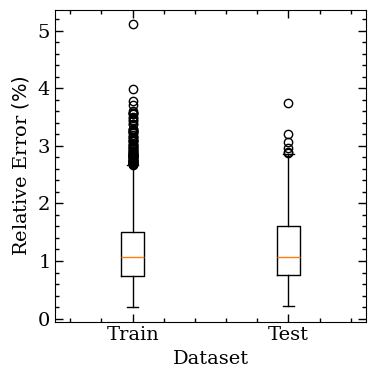

In [126]:
plt.figure(figsize=(4, 4))
plt.boxplot([train_error.numpy()*100, test_error.numpy()*100])
plt.xticks([1, 2], ['Train', 'Test'])
plt.gca().set_box_aspect(1)
plt.ylabel(r'Relative Error $(\%)$')
plt.xlabel('Dataset')
plt.tight_layout()
plt.savefig(f'{directory}/fig1.pdf')
plt.show()

In [127]:
min_index = np.argsort(test_error.numpy())[0]
max_index = np.argsort(test_error.numpy())[-1]
median_index = np.argsort(test_error.numpy())[test_error.shape[0]//2]

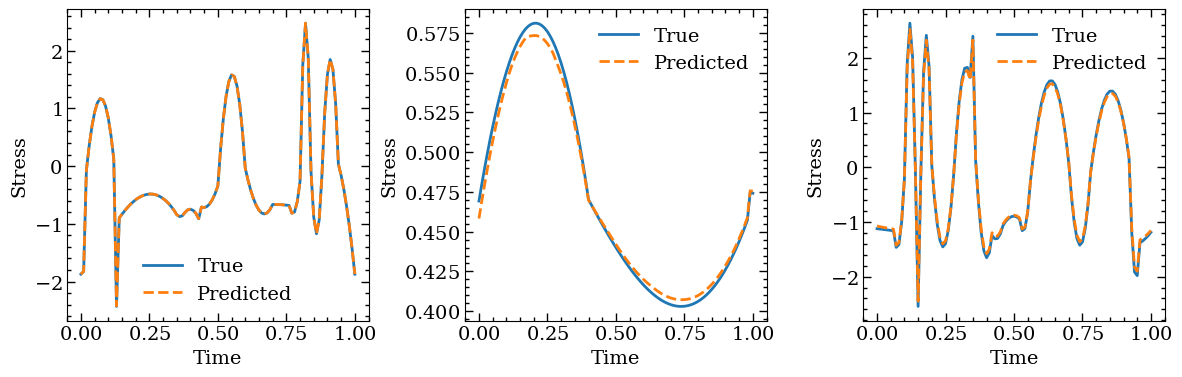

In [128]:
fig, axs = plt.subplots(figsize=(12,4), nrows=1, ncols=3)
index = min_index
axs[0].plot(time, test_y[index], label='True', linewidth=2)
axs[0].plot(time, test_y_pred[index], '--', label='Predicted', linewidth=2)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Stress')
axs[0].legend()
index = median_index
axs[1].plot(time, test_y[index], label='True', linewidth=2)
axs[1].plot(time, test_y_pred[index], '--', label='Predicted', linewidth=2)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Stress')
axs[1].legend()
index = max_index
axs[2].plot(time, test_y[index], label='True', linewidth=2)
axs[2].plot(time, test_y_pred[index], '--', label='Predicted', linewidth=2)
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Stress')
axs[2].legend()
plt.tight_layout()
plt.savefig(f'{directory}/fig2.pdf')
plt.show()

In [22]:
error = (test_y_pred - test_y.numpy())*100

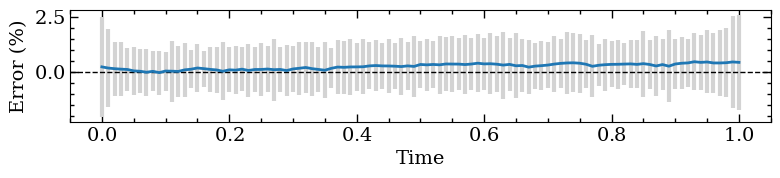

In [129]:
from matplotlib.ticker import ScalarFormatter
plt.figure(figsize=(8, 2))
plt.errorbar(time, np.mean(error, axis=0).flatten(), yerr=np.std(error, axis=0).flatten(), ecolor='lightgray', elinewidth=3, capsize=0)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax = plt.gca()
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='y', style='sci', scilimits=(-2, 2))  # Use scientific notation
plt.xlabel('Time')
plt.ylabel('Error (%)')
plt.tight_layout() 
plt.savefig(f'{directory}/fig3.pdf')
plt.show()

In [111]:
# fig, axs = plt.subplots(figsize=(4,4), nrows=1, ncols=1)
# index = min_index
# axs.plot(time, test_y[index], label='True', linewidth=2)
# axs.plot(time, test_y_pred[index], '--', label='Predicted', linewidth=2)
# index = median_index
# axs.plot(time, test_y[index], label='True', linewidth=2)
# axs.plot(time, test_y_pred[index], '--', label='Predicted', linewidth=2)
# index = max_index
# axs.plot(time, test_y[index], label='True', linewidth=2)
# axs.plot(time, test_y_pred[index], '--', label='Predicted', linewidth=2)
# # axs.legend()
# plt.tight_layout()
# plt.show()

In [45]:
import time 

In [72]:
step_size = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200]
time_step_size = [s/5000 for s in step_size]
rel_error = {}
time_taken = {}
for j in range(len(step_size)):
    print(time_step_size[j])
    vmm = mm.ViscoelasticMaterialModel(
        energy_input_dim,
        energy_hidden_dim,
        dissipation_input_dim,
        dissipation_hidden_dim,
        ae_E.encoder,
        ae_nu.encoder,
        dt = time_step_size[j]
    ).to(device)
    lit = LitVMM.load_from_checkpoint(checkpoint_path=CKPT_PATH, model=vmm, name="vmm_", loss_type="mse")
    
    data_file = args.data_path
    content = open(data_file, "r").read().strip()
    data_files = [file.strip() for file in content.split("\n")]

    data0 = pickle.load(open(data_files[0], 'rb'))
    data1 = pickle.load(open(data_files[1], 'rb'))
    data2 = pickle.load(open(data_files[2], 'rb'))
    data3 = pickle.load(open(data_files[3], 'rb'))
    data_map = {0: data0, 1: data1, 2: data2, 3: data3}

    relevant_cols = ['strain', 'strain_rate', 'stress', 'E', 'nu', 'E_prime', 'nu_prime', 'kernel']
    data = {}
    for col in relevant_cols:
        data[col] = []
        for i in range(4):
            data_i = data_map[i]
            if col in ['strain', 'strain_rate', 'stress', 'kernel']:
                data[col].append(data_i[col][:,::step_size[j]]) 
            else:
                data[col].append(data_i[col])
        data[col] = np.concatenate(data[col], axis=0)

    test_x = (torch.tensor(data['strain'][args.test_indices], dtype=dtype), torch.tensor(data['strain_rate'][args.test_indices], dtype=dtype), torch.tensor(data['E'][args.test_indices], dtype=dtype), torch.tensor(data['nu'][args.test_indices], dtype=dtype))
    test_y = torch.tensor(data['stress'][args.test_indices], dtype=dtype)
    test_loader = DataLoader(torch.utils.data.TensorDataset(*test_x, test_y), batch_size=args.batch_size, shuffle=False)

    test_y_pred = []
    test_iv_pred = []
    tic = time.time()
    for batch in test_loader:
        strain, strain_rate, E, nu, stress = batch
        s, iv = lit.model(strain, strain_rate, E, nu)
        test_y_pred.append(s.detach())
        test_iv_pred.append(iv.detach())
    toc = time.time()

    test_y_pred = torch.cat(test_y_pred, dim=0).cpu().numpy()
    test_iv_pred = torch.cat(test_iv_pred, dim=0).cpu().numpy()
    rel_error[time_step_size[j]] = loss_function.L2RelativeError(torch.tensor(test_y_pred), test_y, reduction='mean').item()*100
    time_taken[time_step_size[j]] = (toc - tic)/60  # in minutes

0.001
0.002
0.003
0.004
0.005
0.006
0.007
0.008
0.009
0.01
0.012
0.014
0.016
0.018
0.02
0.024
0.028
0.032
0.036
0.04


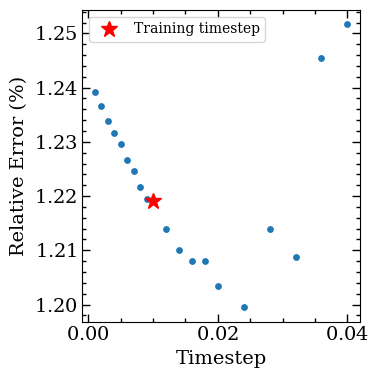

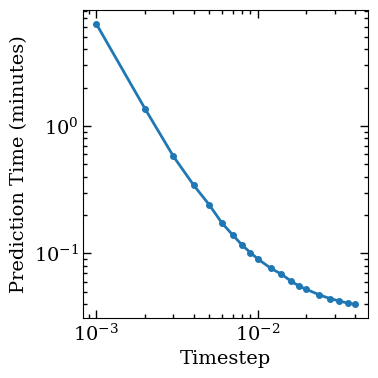

In [131]:
plt.figure(figsize=(4,4))
plt.scatter(rel_error.keys(), rel_error.values(), marker='o', s=15)
plt.plot([0.01], [rel_error[0.01]], 'r*', label='Training timestep', markersize=12)
plt.xlabel('Timestep')
plt.ylabel('Relative Error (%)')
plt.legend(loc='upper left', frameon=True, fontsize=10)
plt.tight_layout()
plt.savefig(f'{directory}/fig4.pdf')
plt.show()
plt.figure(figsize=(4,4))
plt.loglog(time_taken.keys(), time_taken.values(), marker='o')
plt.ylabel('Prediction Time (minutes)')
plt.xlabel('Timestep')
plt.tight_layout()
plt.savefig(f'{directory}/fig5.pdf')
plt.show()

In [87]:
1

1